In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as preproc
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree,metrics
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import statsmodels.api as sm

In [2]:
data=pd.read_csv('AllFeatures.csv')
df = pd.read_excel('DATACASE1.xlsx')
y=np.array(df.LoadFactor)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Backward Elimination
cols = list(data.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = data[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['FlightNumber', 'SeatCapacity', 'Month', 'Hour', 'Dayofweek', 'Dayofyear', 'Quarter', 'QuarterStart', 'QuarterEnd', 'MonthStart', 'YearStart', 'YearEnd', 'AirlineAY', 'AirlineBJ', 'AirlineBT', 'AirlineCD', 'AirlineCL', 'AirlineCN', 'AirlineDO', 'AirlineDU', 'AirlineE4', 'AirlineEM', 'AirlineEN', 'AirlineFB', 'AirlineFK', 'AirlineFO', 'AirlineFP', 'AirlineFZ', 'AirlineGQ', 'AirlineIA', 'AirlineIK', 'AirlineIR', 'AirlineJE', 'AirlineJN', 'AirlineJNL', 'AirlineJZ', 'AirlineKJ', 'AirlineKL', 'AirlineKM', 'AirlineKN', 'AirlineKO', 'AirlineKU', 'AirlineLJ', 'AirlineLW', 'AirlineLZ', 'AirlineMC', 'AirlineMD', 'AirlineML', 'AirlineNH', 'AirlineNI', 'AirlineNU', 'AirlineNV', 'AirlineNW', 'AirlinePJ', 'AirlinePL', 'AirlinePO', 'AirlinePU', 'AirlinePW', 'AirlineSH', 'AirlineSQ', 'AirlineSV', 'AirlineUI', 'AirlineUK', 'AirlineUU', 'AirlineV7', 'AirlineVJ', 'AirlineVW', 'AirlineW9', 'AirlineWU', 'AirlineXG', 'AirlineYQ', 'AirlineYU', 'AirlineZB', 'AirlineZD', 'AirlineZL', 'AirlineZP', 'AirlineZT',

In [5]:
X_selected=np.array(data[selected_features_BE].copy())

In [330]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.30, random_state=42)

In [331]:
y_test_idx=[list(y).index(el) for el in y_test]

In [332]:
model= RandomForestRegressor(n_estimators=50,n_jobs=-1)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [333]:
y_pred=model.predict(X_test)

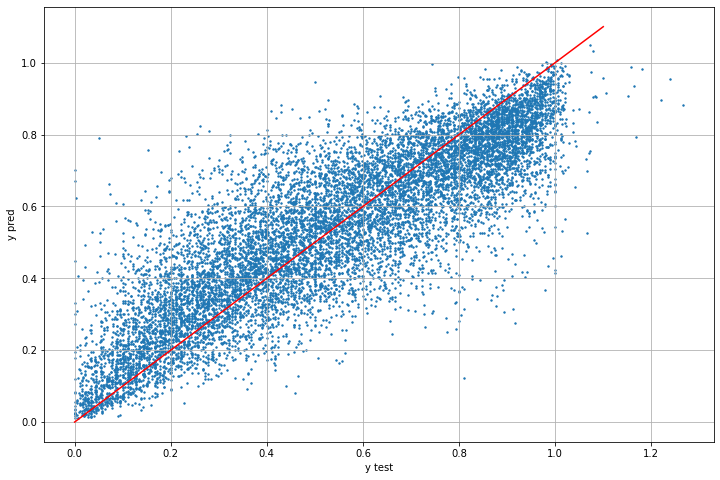

In [334]:
plt.figure(figsize=(12,8))
# plt.scatter(np.sort(y_test),np.sort(ypred),s=1)
plt.scatter(y_test,y_pred,s=2)
plt.xlabel('y test');plt.ylabel('y pred')
plt.plot(np.linspace(0,1.1),np.linspace(0,1.1),'r')
#plt.plot(np.linspace(0,max(y_test)),np.linspace(0,max(y_test)),'r')
plt.grid()
plt.show()

In [335]:
np.mean(np.abs((y_test-y_pred)))

0.11001431032941601

In [336]:
np.mean((y_test-y_pred)**2)

0.020600888437999135

In [337]:
def estimated_total_accuracy(y,y_esti,SC_non_norm):
    #Deviation per flight = (Actual passengers – Forecasted passengers) / Actual passengers per flight
    #Accuracy per flight = 100% - | Deviation per flight |
    
    Actual_pass=np.array(y).T*SC_non_norm
    Forecast_pass=y_esti.T*SC_non_norm
    
    ind0=np.where(Actual_pass==0)[0]
    
    Actual_pass= np.delete(Actual_pass,ind0)
    Forecast_pass= np.delete(Forecast_pass,ind0)

    Dev= (np.abs(Actual_pass-Forecast_pass))/Actual_pass

    Exp_acc= 1-Dev
    T_exp_acc=np.mean(Exp_acc)*100

    return T_exp_acc


def compute_mse(X,beta,y):
    yhat = np.matmul(X, beta)
    res = (y - yhat) ** 2    
    mse = np.mean(res)
    
    return mse, res, yhat

In [338]:
SC_non_norm=np.array(df.SeatCapacity[y_test_idx])

In [339]:
T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
print('Total Expected Accuracy:',T_ex_acc)

Total Expected Accuracy: 60.45965843443979


### Tune criterion

In [306]:
n_estimator=list(range(100,500,50))

# Better way of doing k fold cross validation
K=5
kf = KFold(n_splits=K)
Error0=np.zeros([K,len(n_estimator)])

for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
    X_train = X_selected[train_index]
    y_train = y[train_index]
    X_test = X_selected[test_index]
    y_test = y[test_index]
    y_test_idx=[list(y).index(el) for el in y_test]

    for j,c in enumerate(n_estimator):
        # train
        model= RandomForestRegressor(n_estimators=c,n_jobs=-1)
        model.fit(X_train,y_train)
        # predict
        y_pred=model.predict(X_test)
        # compute accuracy
        SC_non_norm=np.array(df.SeatCapacity[y_test_idx])
        T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
        Error0[i,j]=T_ex_acc
    print(i/K,'folds completed')

0.0 folds completed
0.2 folds completed
0.4 folds completed
0.6 folds completed
0.8 folds completed


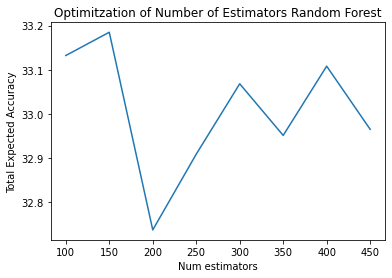

In [307]:
plt.plot(list(range(100,500,50)),np.mean(Error0,axis=0))
plt.xlabel('Num estimators');plt.ylabel('Total Expected Accuracy')
plt.title('Optimitzation of Number of Estimators Random Forest')
plt.savefig('Num_est.png');plt.show()

In [308]:
n_est_opt=150

In [309]:
maxfeat=['auto','sqrt','log2',0.5]

# Better way of doing k fold cross validation
K=5
kf = KFold(n_splits=K)
Error1=np.zeros([K,len(maxfeat)])

for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
    X_train = X_selected[train_index]
    y_train = y[train_index]
    X_test = X_selected[test_index]
    y_test = y[test_index]
    y_test_idx=[list(y).index(el) for el in y_test]

    for j,c in enumerate(maxfeat):
        # train
        model= RandomForestRegressor(n_estimators=n_est_opt,max_features=c,n_jobs=-1)
        model.fit(X_train,y_train)
        # predict
        y_pred=model.predict(X_test)
        # compute accuracy
        SC_non_norm=np.array(df.SeatCapacity[y_test_idx])
        T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
        Error1[i,j]=T_ex_acc
    print(int((i+1)/K*5),'folds completed')

1 folds completed
2 folds completed
3 folds completed
4 folds completed
5 folds completed


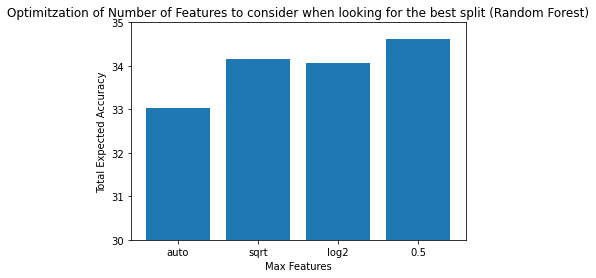

In [315]:
plt.bar(['auto','sqrt','log2','0.5'],np.mean(Error1,axis=0))
plt.ylim([30,35])
plt.xlabel('Max Features');plt.ylabel('Total Expected Accuracy')
plt.title('Optimitzation of Number of Features to consider when looking for the best split (Random Forest)')
plt.savefig('Maxfeat.png');plt.show()

In [316]:
max_feat_opt=0.5

In [317]:
maxsamples=np.linspace(0.1,0.9,9).astype(float)

# Better way of doing k fold cross validation
K=5
kf = KFold(n_splits=K)
Error2=np.zeros([K,len(maxsamples)])

for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
    X_train = X_selected[train_index]
    y_train = y[train_index]
    X_test = X_selected[test_index]
    y_test = y[test_index]
    y_test_idx=[list(y).index(el) for el in y_test]

    for j,c in enumerate(maxsamples):
        # train
        model= RandomForestRegressor(n_estimators=n_est_opt,max_features=max_feat_opt,max_samples=c,n_jobs=-1)
        model.fit(X_train,y_train)
        # predict
        y_pred=model.predict(X_test)
        # compute accuracy
        SC_non_norm=np.array(df.SeatCapacity[y_test_idx])
        T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
        Error2[i,j]=T_ex_acc
    print(int((i+1)/K*5),'folds completed')

1 folds completed
2 folds completed
3 folds completed
4 folds completed
5 folds completed


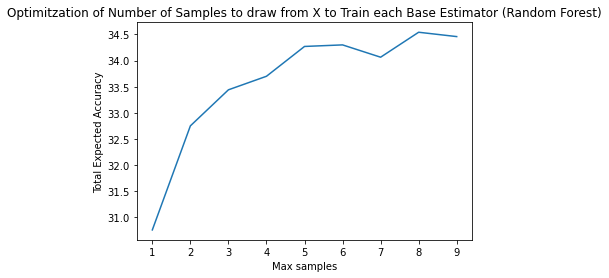

In [318]:
plt.plot(list(range(1,10)),np.mean(Error2,axis=0))
plt.xlabel('Max samples');plt.ylabel('Total Expected Accuracy')
plt.title('Optimitzation of Number of Samples to draw from X to Train each Base Estimator (Random Forest)')
plt.savefig('Maxsamp.png');plt.show()

In [319]:
max_samp_opt=np.round(maxsamples[list(np.mean(Error2,axis=0)).index(max(np.mean(Error2,axis=0)))],2)
max_samp_opt

0.8

In [322]:
min_samples_split=list(range(2,11,1))

# Better way of doing k fold cross validation
K=5
kf = KFold(n_splits=K)
Error3=np.zeros([K,len(min_samples_split)])

for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
    X_train = X_selected[train_index]
    y_train = y[train_index]
    X_test = X_selected[test_index]
    y_test = y[test_index]
    y_test_idx=[list(y).index(el) for el in y_test]

    for j,c in enumerate(min_samples_split):
        # train
        model= RandomForestRegressor(n_estimators=n_est_opt,max_features=max_feat_opt,max_samples=max_samp_opt,
                                     min_samples_split=c,n_jobs=-1)
        model.fit(X_train,y_train)
        # predict
        y_pred=model.predict(X_test)
        # compute accuracy
        SC_non_norm=np.array(df.SeatCapacity[y_test_idx])
        T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
        Error3[i,j]=T_ex_acc
    print(int((i+1)/K*5),'folds completed')

1 folds completed
2 folds completed
3 folds completed
4 folds completed
5 folds completed


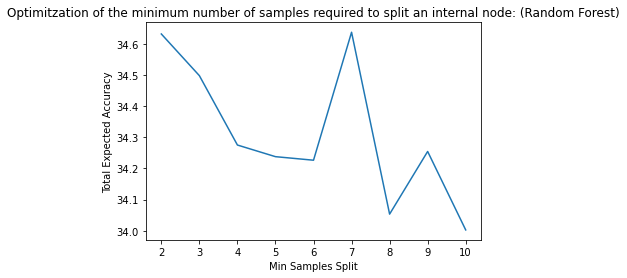

In [323]:
plt.plot(list(range(2,11,1)),np.mean(Error3,axis=0))
plt.xlabel('Min Samples Split');plt.ylabel('Total Expected Accuracy')
plt.title('Optimitzation of the minimum number of samples required to split an internal node: (Random Forest)')
plt.savefig('Min_split.png');plt.show()

In [324]:
min_samp_opt=7

### Train the model again once optimized

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.30, random_state=42)
y_test_idx=[list(y).index(el) for el in y_test]

In [344]:
model= RandomForestRegressor(n_estimators=n_est_opt,max_features=max_feat_opt,max_samples=max_samp_opt,
                             min_samples_split=c,n_jobs=-1)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=0.8, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

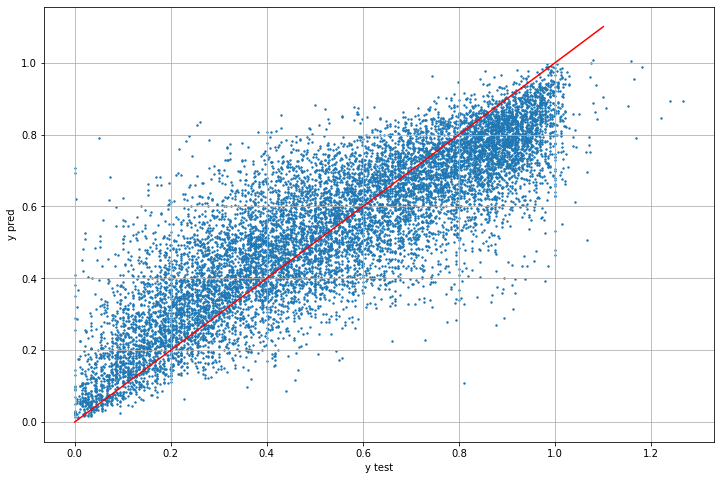

In [328]:
y_pred=model.predict(X_test)
plt.figure(figsize=(12,8))
# plt.scatter(np.sort(y_test),np.sort(ypred),s=1)
plt.scatter(y_test,y_pred,s=2)
plt.xlabel('y test');plt.ylabel('y pred')
plt.plot(np.linspace(0,1.1),np.linspace(0,1.1),'r')
#plt.plot(np.linspace(0,max(y_test)),np.linspace(0,max(y_test)),'r')
plt.grid()
plt.show()

In [329]:
SC_non_norm=np.array(df.SeatCapacity[y_test_idx])
T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
print('Total Expected Accuracy:',T_ex_acc)

Total Expected Accuracy: 59.00524017716339


#### Compute Accuracy without hyperparamter tunning

In [340]:
K=5
kf = KFold(n_splits=K)
Accuracy=np.zeros(K)

for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
    X_train = X_selected[train_index]
    y_train = y[train_index]
    X_test = X_selected[test_index]
    y_test = y[test_index]
    y_test_idx=[list(y).index(el) for el in y_test]
    # train model
    model= RandomForestRegressor(n_jobs=-1) # we leave all the values at DEFAULT
    model.fit(X_train,y_train)
    # predict model
    y_pred=model.predict(X_test)
    SC_non_norm=np.array(df.SeatCapacity[y_test_idx])
    T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
    Accuracy[i]=T_ex_acc;print('Total Expected Accuracy:',T_ex_acc)
    
np.mean(Accuracy)

Total Expected Accuracy: 9.56401167131749
Total Expected Accuracy: 48.292855563455305
Total Expected Accuracy: 26.44399509661195
Total Expected Accuracy: 28.723082152368157
Total Expected Accuracy: 52.69669965235324


33.14412882722122

#### Compute Accuracy using CV

In [343]:
K=5
kf = KFold(n_splits=K)
Accuracy=np.zeros(K)

for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
    X_train = X_selected[train_index]
    y_train = y[train_index]
    X_test = X_selected[test_index]
    y_test = y[test_index]
    y_test_idx=[list(y).index(el) for el in y_test]
    # train model
    model= RandomForestRegressor(n_estimators=n_est_opt,max_features=max_feat_opt,max_samples=max_samp_opt,
                                     min_samples_split=c,n_jobs=-1)
    model.fit(X_train,y_train)
    # predict model
    y_pred=model.predict(X_test)
    SC_non_norm=np.array(df.SeatCapacity[y_test_idx])
    T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
    Accuracy[i]=T_ex_acc;print('Total Expected Accuracy:',T_ex_acc)

Total Expected Accuracy: 4.588221860000711
Total Expected Accuracy: 48.73345515500873
Total Expected Accuracy: 34.75378425383112
Total Expected Accuracy: 28.621207031240115
Total Expected Accuracy: 53.03155138447384


In [247]:
np.mean(Accuracy)

79.29797657466429

With min_leaf=3, Accuracy=83.18627648349691

In [244]:
K=5
kf = KFold(n_splits=K)
train_index,test_index=list(kf.split(X_selected))[3]
print(len(train_index))
print(len(test_index))
print(len(test_index)/len(train_index))

31559
7890
0.2500079216705219


### Training with the best training fold

In [199]:
train_index,test_index=list(kf.split(X_selected))[3]
X_train = X_selected[train_index]
y_train = y[train_index]
X_test = X_selected[test_index]
y_test = y[test_index]
y_test_idx=[list(y).index(el) for el in y_test]

model= RandomForestRegressor(n_estimators=n_est_opt,max_features='auto',max_samples=max_samp_opt,
                             min_samples_split=min_samp_opt,n_jobs=-1)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=0.7, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

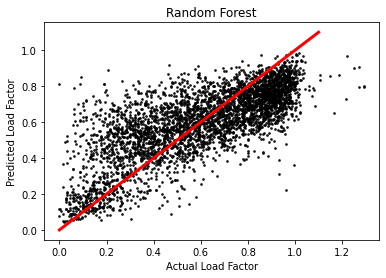

In [209]:
y_pred=model.predict(X_test)
plt.scatter(y_test,y_pred,s=3,alpha=0.8,c ="black")
plt.plot(np.linspace(0,1.1),np.linspace(0,1.1),'r',linewidth=3)
plt.ylabel('Predicted Load Factor');plt.xlabel('Actual Load Factor');plt.title('Random Forest');
plt.savefig('RandomForest.png');plt.show()

In [201]:
SC_non_norm=np.array(data.SeatCapacity[y_test_idx])
T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
print('Total Expected Accuracy:',T_ex_acc)

Total Expected Accuracy: 96.18732464879109


### Plot for every fold

Total Expected Accuracy: 61.01771335761259


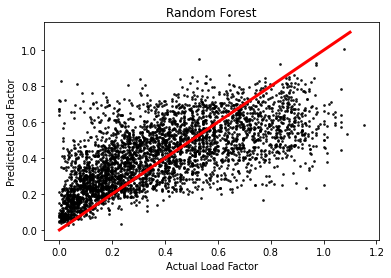

Total Expected Accuracy: 93.61626797966477


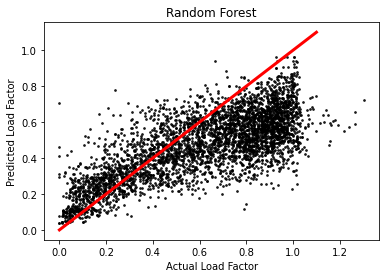

Total Expected Accuracy: 84.32077228921655


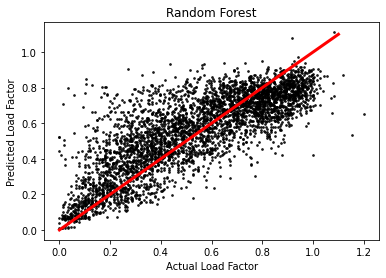

Total Expected Accuracy: 95.21300395030931


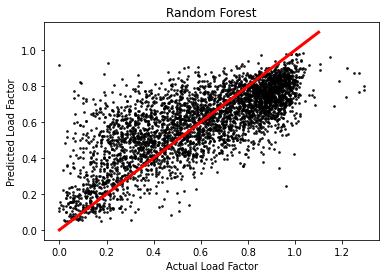

Total Expected Accuracy: 94.48857294243074


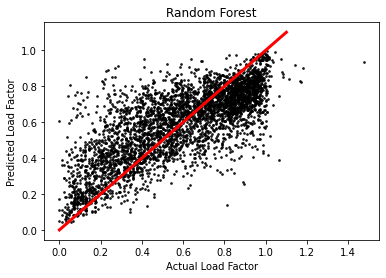

Total Expected Accuracy: 90.01761260142005


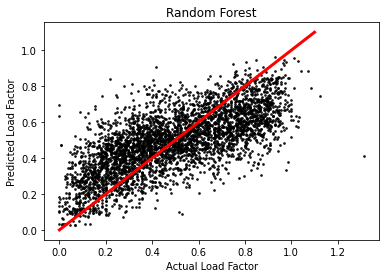

Total Expected Accuracy: 62.05625421117452


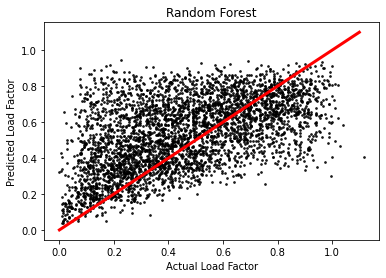

Total Expected Accuracy: 79.7346236784536


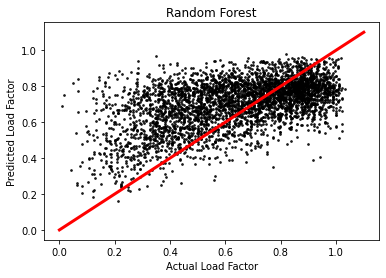

Total Expected Accuracy: 81.03641023102001


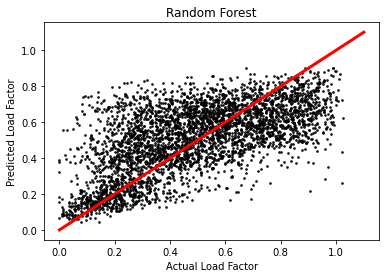

Total Expected Accuracy: 90.00314975348067


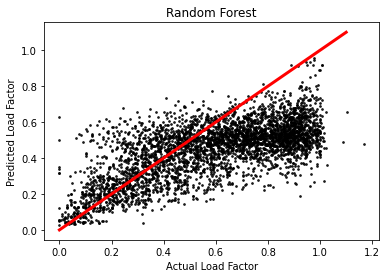

In [210]:
K=10
kf = KFold(n_splits=K)
Accuracy=np.zeros(K)

for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
    X_train = X_selected[train_index]
    y_train = y[train_index]
    X_test = X_selected[test_index]
    y_test = y[test_index]
    y_test_idx=[list(y).index(el) for el in y_test]
    # train model
    model= RandomForestRegressor(n_estimators=n_est_opt,max_features='auto',max_samples=max_samp_opt,
                                 min_samples_split=min_samp_opt,n_jobs=-1)
    model.fit(X_train,y_train)
    # predict model
    y_pred=model.predict(X_test)
    SC_non_norm=np.array(data.SeatCapacity[y_test_idx])
    T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
    Accuracy[i]=T_ex_acc;print('Total Expected Accuracy:',T_ex_acc)
    plt.scatter(y_test,y_pred,s=3,alpha=0.8,c ="black")
    plt.plot(np.linspace(0,1.1),np.linspace(0,1.1),'r',linewidth=3)
    plt.ylabel('Predicted Load Factor');plt.xlabel('Actual Load Factor');plt.title('Random Forest');
    plt.show()

## Optimize without using CV

# Predict in the new csv and generate output.txt file

In [214]:
future_data=pd.read_excel('Future_Schedule.xlsx')
future_data

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity
0,2022-03-01 05:45:00,UK,1315,YXX,319,J,CA,131
1,2022-03-01 07:15:00,PW,950,YLW,319,J,CA,143
2,2022-03-01 06:45:00,VW,770,YYZ,320,J,CA,220
3,2022-03-01 06:40:00,DO,2568,YXU,32N,J,CA,180
4,2022-03-01 07:30:00,AY,984,YYG,320,J,CA,174
...,...,...,...,...,...,...,...,...
4808,2022-03-31 21:05:00,SV,1988,YYJ,73H,J,CA,186
4809,2022-03-31 20:55:00,MD,1242,YBR,321,J,CA,230
4810,2022-03-31 21:50:00,LJ,506,YUL,320,J,CA,186
4811,2022-03-31 20:30:00,LJ,772,YEG,320,J,CA,186


In [264]:
DateTime_dic = {'Day':[],'Month':[],'Year':[],'Hour':[],'Minute':[],'Dayofweek':[],'Dayofyear':[],'Quarter':[],
               'QuarterStart':[],'QuarterEnd':[],'MonthStart':[],'MonthEnd':[],'YearStart':[],'YearEnd':[]}

for a in future_data['ScheduleTime']:
    DateTime_dic['Day'].append(a.day)
    DateTime_dic['Month'].append(a.month)
    DateTime_dic['Year'].append(a.year)
    DateTime_dic['Hour'].append(a.hour)
    DateTime_dic['Minute'].append(a.minute)
    DateTime_dic['Dayofweek'].append(a.dayofweek)
    DateTime_dic['Dayofyear'].append(a.dayofyear)
    DateTime_dic['Quarter'].append(int(a.quarter))
    DateTime_dic['QuarterStart'].append(int(a.is_quarter_start))
    DateTime_dic['QuarterEnd'].append(int(a.is_quarter_end))
    DateTime_dic['MonthStart'].append(int(a.is_month_start))
    DateTime_dic['MonthEnd'].append(int(a.is_month_end))
    DateTime_dic['YearStart'].append(int(a.is_year_start))
    DateTime_dic['YearEnd'].append(int(a.is_year_end))
    
X=future_data[['Airline','FlightNumber','Destination','AircraftType','FlightType','Sector','SeatCapacity']]
pd_time=pd.DataFrame.from_dict(DateTime_dic)
pd_time

,Day,Month,Year,Hour,Minute,Dayofweek,Dayofyear,Quarter,QuarterStart,QuarterEnd,MonthStart,MonthEnd,YearStart,YearEnd
0,1,3,2022,5,45,1,60,1,0,0,1,0,0,0
1,1,3,2022,7,15,1,60,1,0,0,1,0,0,0
2,1,3,2022,6,45,1,60,1,0,0,1,0,0,0
3,1,3,2022,6,40,1,60,1,0,0,1,0,0,0
4,1,3,2022,7,30,1,60,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,31,3,2022,21,5,3,90,1,0,1,0,1,0,0
4809,31,3,2022,20,55,3,90,1,0,1,0,1,0,0
4810,31,3,2022,21,50,3,90,1,0,1,0,1,0,0
4811,31,3,2022,20,30,3,90,1,0,1,0,1,0,0


In [272]:
DateTime_dic = {'Day':[],'Month':[],'Year':[],'Hour':[],'Minute':[],'Dayofweek':[],'Dayofyear':[],'Quarter':[],
               'QuarterStart':[],'QuarterEnd':[],'MonthStart':[],'MonthEnd':[],'YearStart':[],'YearEnd':[]}

for a in future_data['ScheduleTime']:
    DateTime_dic['Day'].append(a.day)
    DateTime_dic['Month'].append(a.month)
    DateTime_dic['Year'].append(a.year)
    DateTime_dic['Hour'].append(a.hour)
    DateTime_dic['Minute'].append(a.minute)
    DateTime_dic['Dayofweek'].append(a.dayofweek)
    DateTime_dic['Dayofyear'].append(a.dayofyear)
    DateTime_dic['Quarter'].append(int(a.quarter))
    DateTime_dic['QuarterStart'].append(int(a.is_quarter_start))
    DateTime_dic['QuarterEnd'].append(int(a.is_quarter_end))
    DateTime_dic['MonthStart'].append(int(a.is_month_start))
    DateTime_dic['MonthEnd'].append(int(a.is_month_end))
    DateTime_dic['YearStart'].append(int(a.is_year_start))
    DateTime_dic['YearEnd'].append(int(a.is_year_end))
    
X=future_data[['Airline','FlightNumber','Destination','AircraftType','FlightType','Sector','SeatCapacity']]
pd_time=pd.DataFrame.from_dict(DateTime_dic)
X_all=X.join(pd_time)
X_all.AircraftType=X_all.AircraftType.astype('str')
X_all.Year=X_all.Year.astype('str')
X_ext= X_all.copy()
SC_non_norm=np.array(X_ext['SeatCapacity'])

#Variables that we need to encode: 
str_var=list(X_all.select_dtypes(include='object').columns)
print(str_var)
X_ext=X_ext.drop(columns=str_var)

for var in str_var:
    # creating instance of one-hot-encoder
    enc = OneHotEncoder(handle_unknown='ignore')
    # passing bridge-types-cat column (label encoded values of bridge_types)
    unique_var= list(np.unique(X_all[[var]]))
    enc_df = pd.DataFrame(enc.fit_transform(X_all[[var]]).toarray())
    
    for col in enc_df:
        enc_df=enc_df.rename(columns = {col:var+unique_var[col]})

    #Join dataframes
    X_ext = pd.concat([X_ext,enc_df], axis = 1)
    
X_ext

['Airline', 'Destination', 'AircraftType', 'FlightType', 'Sector', 'Year']


,FlightNumber,SeatCapacity,Day,Month,Hour,Minute,Dayofweek,Dayofyear,Quarter,QuarterStart,...,SectorCA,SectorCN,SectorDK,SectorEG,SectorIQ,SectorIS,SectorQA,SectorSG,SectorUS,Year2022
0,1315,131,1,3,5,45,1,60,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,950,143,1,3,7,15,1,60,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,770,220,1,3,6,45,1,60,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2568,180,1,3,6,40,1,60,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,984,174,1,3,7,30,1,60,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,1988,186,31,3,21,5,3,90,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4809,1242,230,31,3,20,55,3,90,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4810,506,186,31,3,21,50,3,90,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4811,772,186,31,3,20,30,3,90,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [273]:
def normalizeData(data):
    mu = np.mean(data,axis=0)
    omega = np.std(data,axis=0)
    data = (data - mu)/omega
    
    return data, mu
 
def centerData(data): 
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

SC_non_norm=np.array(X_ext['SeatCapacity'])
SC_norm,mu=normalizeData(SC_non_norm)
X_ext.SeatCapacity= SC_norm 


X_ext.Hour= normalizeData(np.array(X_ext['Hour']))[0]
X_ext.Minute= normalizeData(np.array(X_ext['Minute']))[0]
X_ext.FlightNumber= normalizeData(np.array(X_ext['FlightNumber']))[0]
X_ext.Day= normalizeData(np.array(X_ext['Day']))[0]
#X_ext.Month= normalizeData(np.array(X_ext['Month']))[0]


X_ext.Dayofweek= normalizeData(np.array(X_ext['Dayofweek']))[0]
X_ext.Dayofyear= normalizeData(np.array(X_ext['Dayofyear']))[0]
#X_ext.Quarter= normalizeData(np.array(X_ext['Quarter']))[0]
X_ext=X_ext.drop(columns='Year2022')

X_ext

,FlightNumber,SeatCapacity,Day,Month,Hour,Minute,Dayofweek,Dayofyear,Quarter,QuarterStart,...,SectorAE,SectorCA,SectorCN,SectorDK,SectorEG,SectorIQ,SectorIS,SectorQA,SectorSG,SectorUS
0,0.076065,-0.614025,-1.741863,3,-1.723005,1.053274,-0.971251,-1.741863,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.382827,-0.383480,-1.741863,3,-1.303519,-0.704597,-0.971251,-1.741863,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.609129,1.095853,-1.741863,3,-1.513262,1.053274,-0.971251,-1.741863,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.651384,0.327368,-1.741863,3,-1.513262,0.760295,-0.971251,-1.741863,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.340081,0.212096,-1.741863,3,-1.303519,0.174338,-0.971251,-1.741863,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,0.922186,0.442641,1.550940,3,1.632885,-1.290554,0.043209,1.550940,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4809,-0.015713,1.287975,1.550940,3,1.423141,1.639231,0.043209,1.550940,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4810,-0.941040,0.442641,1.550940,3,1.632885,1.346253,0.043209,1.550940,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4811,-0.606615,0.442641,1.550940,3,1.423141,0.174338,0.043209,1.550940,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [283]:
el_not_inX_ext=['AirlineCD', 'AirlineDU', 'AirlineEN', 'AirlineFK', 'AirlineJE', 'AirlineJN', 'AirlineJNL', 
                'AirlineKJ', 'AirlineKM', 'AirlineKN', 'AirlineKO', 'AirlineSQ', 'AirlineUI', 'AirlineUU', 
                'AirlineV7', 'AirlineW9', 'AirlineZB', 'DestinationAXX', 'DestinationBGE', 'DestinationCUN', 
                'DestinationCWS', 'DestinationDGW', 'DestinationEAT', 'DestinationEFB', 'DestinationEKO', 
                'DestinationHUL', 'DestinationIVH', 'DestinationJFN', 'DestinationLEE', 'DestinationLOZ', 
                'DestinationMOR', 'DestinationMSD', 'DestinationMTM', 'DestinationNQA', 'DestinationNUW', 
                'DestinationPSP', 'DestinationTDW', 'DestinationTDZ', 'DestinationTKE', 'DestinationYCW', 
                'DestinationYGL', 'DestinationYPP', 'DestinationYQI', 'DestinationYTK', 'DestinationYUD', 
                'DestinationZBF', 'AircraftType31B', 'AircraftType351', 'AircraftType7S8', 'AircraftTypeER3', 
                'AircraftTypeM83', 'SectorMX', 'Year2021']

In [284]:
for el in el_not_inX_ext:
    X_ext[el]=0
X_ext

,FlightNumber,SeatCapacity,Day,Month,Hour,Minute,Dayofweek,Dayofyear,Quarter,QuarterStart,...,DestinationYTK,DestinationYUD,DestinationZBF,AircraftType31B,AircraftType351,AircraftType7S8,AircraftTypeER3,AircraftTypeM83,SectorMX,Year2021
0,0.076065,-0.614025,-1.741863,3,-1.723005,1.053274,-0.971251,-1.741863,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.382827,-0.383480,-1.741863,3,-1.303519,-0.704597,-0.971251,-1.741863,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.609129,1.095853,-1.741863,3,-1.513262,1.053274,-0.971251,-1.741863,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1.651384,0.327368,-1.741863,3,-1.513262,0.760295,-0.971251,-1.741863,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.340081,0.212096,-1.741863,3,-1.303519,0.174338,-0.971251,-1.741863,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,0.922186,0.442641,1.550940,3,1.632885,-1.290554,0.043209,1.550940,1,0,...,0,0,0,0,0,0,0,0,0,0
4809,-0.015713,1.287975,1.550940,3,1.423141,1.639231,0.043209,1.550940,1,0,...,0,0,0,0,0,0,0,0,0,0
4810,-0.941040,0.442641,1.550940,3,1.632885,1.346253,0.043209,1.550940,1,0,...,0,0,0,0,0,0,0,0,0,0
4811,-0.606615,0.442641,1.550940,3,1.423141,0.174338,0.043209,1.550940,1,0,...,0,0,0,0,0,0,0,0,0,0


In [285]:
X_selected_output=np.array(X_ext[selected_features_BE].copy())

In [286]:
K=5
kf = KFold(n_splits=K)
train_index,test_index=list(kf.split(X_selected))[2]
X_train = X_selected[train_index]
y_train = y[train_index]
X_test = X_selected[test_index]
y_test = y[test_index]
y_test_idx=[list(y).index(el) for el in y_test]

In [287]:
model= RandomForestRegressor(n_estimators=n_est_opt,max_features='auto',max_samples=max_samp_opt,
                             min_samples_split=min_samp_opt,n_jobs=-1)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=0.7, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [290]:
y_pred=model.predict(np.array(X_selected_output))
future_data['LoadFactor']=y_pred
future_data

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2022-03-01 05:45:00,UK,1315,YXX,319,J,CA,131,0.292568
1,2022-03-01 07:15:00,PW,950,YLW,319,J,CA,143,0.581351
2,2022-03-01 06:45:00,VW,770,YYZ,320,J,CA,220,0.394068
3,2022-03-01 06:40:00,DO,2568,YXU,32N,J,CA,180,0.528596
4,2022-03-01 07:30:00,AY,984,YYG,320,J,CA,174,0.277295
...,...,...,...,...,...,...,...,...,...
4808,2022-03-31 21:05:00,SV,1988,YYJ,73H,J,CA,186,0.514936
4809,2022-03-31 20:55:00,MD,1242,YBR,321,J,CA,230,0.532860
4810,2022-03-31 21:50:00,LJ,506,YUL,320,J,CA,186,0.591953
4811,2022-03-31 20:30:00,LJ,772,YEG,320,J,CA,186,0.547619
